In [124]:
import ROOT
#import h5py
import h5pickle as h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import Waveform_Analysis.PMT_POSITIONS as pmtpos
import Waveform_Analysis.data_processing.settings as settings
import Waveform_Analysis.CABLE_DELAYS as cableDelays
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.mlab as mlab
import math
from multiprocessing import Pool

#basefilename = "/mnt/data/eos/run312/eos_data-diagnostic-run-312"
basefilename = "/mnt/data/eos/run357/eos_data-diagnostic-run-357"
filenames = []
runTitle = "run 357"

totalFiles = 99
h5Files = []
for i in range(0,totalFiles+1):
    filenames.append(basefilename + "."+ str(i) + ".h5")
    h5Files.append(h5py.File(basefilename + "."+ str(i) + ".h5", "r"))

# I hate this too don't worry
muonMapping ={
    "115-S1": (15, 13), # Middle Inner
    "88-S1": (15, 12), # Top inner
    "303-S1": (15, 14), # Top outer
    "307-S2": (14,12), # Bottom outer
    "52-S2": (14,13), # Bottom inner
    "47-S1": (14, 14) # Middle outer
}

board = 24312
board_id = 16
channel_id = 13

muonBoards = ["24311", "24312"]
muonChannels = [12,13,14]

voltage_offset = 1762 #Not needed started using the average voltage to find the baseline
trigger_threshhold = -10

voltage_offsets = { 
    "24311": 1762,
    "24312": 1760
}

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def countNhits(eventNumber, h5File) -> int: # Grabs amount of triggered pmts in a given event
    nhits = 0
    #with h5py.File(filename, "r") as h5File:
    for board in pmtpos.boards.values():
        boardId = list(pmtpos.boards.keys())[board]

        digit = h5File[str(boardId)]
        bits = digit.attrs['bits']
        nsamples = digit.attrs["samples"]
        if board == 16: # Last board is not used for pmts(?)
            continue
        
        for channel in range(0,15):
            if (board,channel) in muonMapping.values(): # Do not count the muon paddles
                continue
                
            
            channeldata = digit["ch%d" % channel]
            sampledata = channeldata["samples"]
            dynamic_range = channeldata.attrs["dynamic_range"]
            dv = dynamic_range/np.power(2,bits)
            dt = digit.attrs["ns_sample"]
            
            sample = sampledata[eventNumber]
            meanVoltage = np.mean(sample)
            #voltage = (sample*dv)-voltage_offsets[board]
            voltage = (sample-meanVoltage)*dv # Now using the meaning voltage to set the baseline
            minvoltage = voltage[np.argmin(voltage)]
            maxvoltage = voltage[np.argmax(voltage)]
        
            #print(minvoltage)
            #time = np.arange(0, nsamples*dt, dt)
            if minvoltage < trigger_threshhold:
                #plt.plot(time, voltage)
                #plt.show()
                nhits += 1
                    
    return nhits
    
print(countNhits(4,h5Files[0]))

print(pmtpos.boards)
print("Finished loading")

11
{'19858': 0, '24190': 1, '24191': 2, '24192': 3, '24193': 4, '24194': 5, '24195': 6, '24196': 7, '24305': 8, '24306': 9, '24307': 10, '24308': 11, '24309': 12, '24310': 13, '24311': 14, '24312': 15, '19857': 16}
Finished loading


# Process Waveforms for the muon paddles

4073


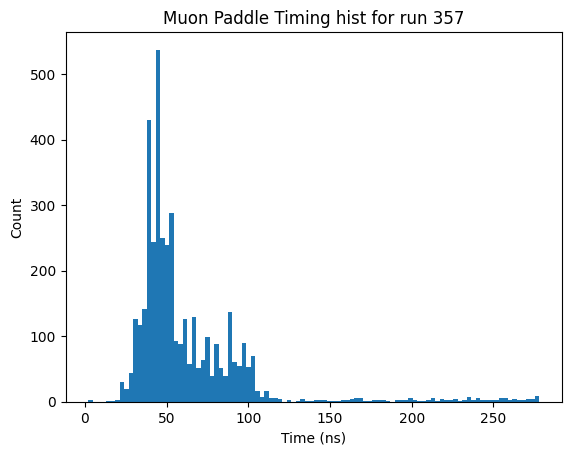

In [125]:
muonHits = {
    "115-S1": [],
    "88-S1": [],
    "303-S1": [],
    "307-S2": [],
    "52-S2": [],
    "47-S1": []
}

triggered_samples = []
times = []
trigger_threshhold = -10
time = None

for f in h5Files:
    
    for board in muonBoards:
        digit = f[str(board)]
        bits = digit.attrs['bits']
        nsamples = digit.attrs["samples"]
        for channelId in muonChannels:
            channel = digit["ch%d" % channelId]
            data = channel["samples"]
            dynamic_range = channel.attrs["dynamic_range"]
            dv = dynamic_range/np.power(2,bits)
            dt = digit.attrs["ns_sample"]

            time = np.arange(0, nsamples*dt, dt)

            i = 0 #Keeps track of what event a sample came from
            for sample in data:
                meanVoltage = np.mean(sample)
                #voltage = (sample*dv)-voltage_offsets[board]
                voltage = (sample-meanVoltage)*dv # Now using the meaning voltage to set the baseline
                minvoltage = voltage[np.argmin(voltage)]
                maxvoltage = voltage[np.argmax(voltage)]
            
                #print(minvoltage)
                if minvoltage < trigger_threshhold:

                    #nhits = countNhits(0, f)

                    muonHits[list(muonMapping.keys())[list(muonMapping.values()).index((pmtpos.boards[board],channelId))]].append((voltage,time[np.argmin(voltage)], i, f))
                    
                    triggered_samples.append(voltage)
                    times.append(time[np.argmin(voltage)])
                    # # print("test")
                    # plt.plot(time,(voltage))
            
                    # plt.xlabel("Time (ns)")
                    # plt.ylabel("Voltage (mV)")
                    # plt.ylim([-30,10])
                    # plt.show()

                i += 1
# print(len(times))
# plt.plot(time,triggered_samples[10])
# plt.plot(time, [trigger_threshhold]*(len(time)))
# plt.ylim([-30,10])
# #plt.xlim([0,250])
#plt.show()
print(len(times))
plt.hist(times, bins=100)
plt.title("Muon Paddle Timing hist for " + runTitle)
plt.xlabel("Time (ns)")
plt.ylabel("Count")
plt.show()

# Get nhit distribution without muon paddles

499


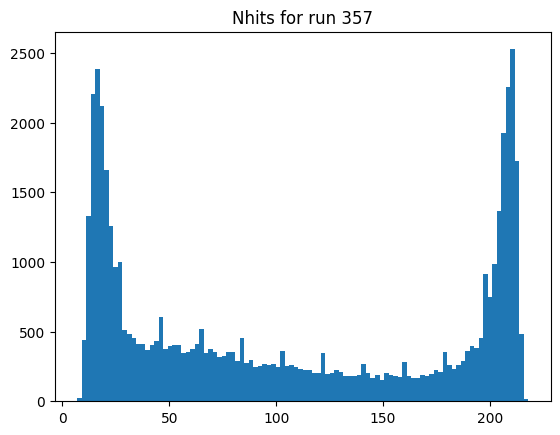

In [145]:
totalEvents = len(h5Files[0][str(24312)]["ch%d" % 0]["samples"])-1

print(totalEvents)

def spawnProcesses(file):
    #print("Started processing " + str(file))
    #totalEvents = len(file[0][str(24312)]["ch%d" % 0]["samples"])
    nhit = []
    i=0
    while i < totalEvents:
        nhit.append(countNhits(i, file))
        i += 1
        
    #print("Done processing " + str(file))
    return nhit

nhits = []
# for h5File in h5Files:
#     print(h5File)
#     i = 0
#     while i < totalEvents:
        
#         nhits.append(countNhits(i, h5File))

#         i += 1
with Pool(len(h5Files)) as p:
    nhits = nhits + p.map(spawnProcesses, h5Files)
    #nhits.extend(p.map(spawnProcesses, h5Files))
    #np.concatenate(nhits, p.map(spawnProcesses, h5Files))
#print(nhits)
plt.title("Nhits for " + runTitle)
plt.hist(np.asarray(nhits).flatten(), bins=100)
plt.show()

55.14454277286136 41.907888789403884
47.31811697574893 31.418532650116862
48.10223642172524 25.48925278971454
94.99288762446658 23.3520573791264
73.95170454545455 37.765318196172544
50.49016641452345 31.837360570742813


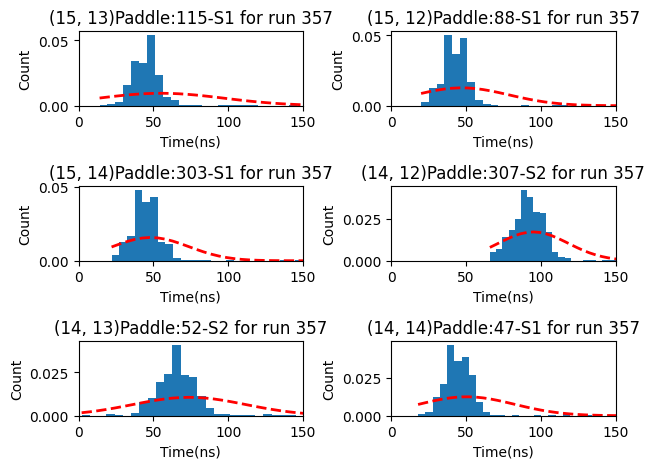

In [129]:
#print(muonHits["115-S1"][0])
# plt.plot(time, muonHits["115-S1"][0][0])
# plt.show()

muonTimingHist, muonTimingAxis = plt.subplots(3,2)

muonFigureMapping ={
    "115-S1": (0, 0), # Middle Inner
    "88-S1": (0, 1), # Top inner
    "303-S1": (1, 0), # Top outer
    "307-S2": (1,1), # Bottom outer
    "52-S2": (2,0), # Bottom inner
    "47-S1": (2, 1) # Middle outer
}

for muonPaddle, samples in muonHits.items():
    muonTiming = []
    for sample in samples:
        #print(sample)
        muonTiming.append(sample[1])

    (mu, sigma) = norm.fit(muonTiming)
    print(mu, sigma)
    n, bins, patches = muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].hist(muonTiming,density=True,bins=50)

    y = norm.pdf(bins,mu,sigma)
    l = muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].plot(bins,y,"r--",linewidth=2)
    muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_title(str(muonMapping[muonPaddle]) + "Paddle:"+ muonPaddle + " for " + runTitle)
    muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_xlabel("Time(ns)")
    muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_ylabel("Count")
    muonTimingAxis[muonFigureMapping[muonPaddle][0],muonFigureMapping[muonPaddle][1]].set_xlim([0,150])

#plt.title("Pulse time distribution")
plt.tight_layout()
plt.show()

# Display Waveforms for a specific paddle

In [ ]:
paddle = "307-S2"

for value in muonHits["307-S2"]:
    plt.plot(time,value[0])
    plt.title(str(muonMapping[paddle]) + " Event:" + str(value[2]))
    plt.xlabel("Time(ns)")
    plt.ylabel("Voltage(mV)")
    plt.show()

# Detection of Double Events and plottoing the nhits

150


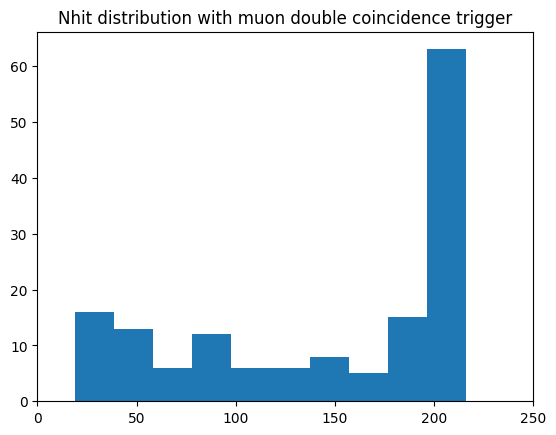

In [149]:
"115-S1"
"88-S1"
"52-S2"

count = 0
doubleTriggers = []
for paddle1, paddle2 in zip(["115-S1","115-S1", "47-S1", "47-S1"], ["88-S1", "303-S1", "88-S1", "303-S1"]):
    for sample in muonHits[paddle1]:
        for sample2 in muonHits[paddle2]:
            if (sample[2] == sample2[2]) and (sample[3] == sample2[3]) and (-1 < sample[1]-sample2[1] < 1):
                #if (-1 < sample[1]-sample2[1] < 1) and ((sample[1] != 0) or (sample2[1] != 0) and (sample[3] == sample3[3])):'
                #nhits = countNhits(sample2[2], sample2[3])
                #print("Nhits: " + str(countNhits(sample2[2], sample2[3])))
                #plt.plot(time,sample[0], label="115-S1")
                #plt.plot(time,sample2[0], label="88-S1")
                #plt.xlim([0,100])
                #plt.legend()
                #plt.show()
    
                doubleTriggers.append(countNhits(sample2[2], sample2[3]))

print(len(doubleTriggers))
plt.title("Nhit distribution with muon double coincidence trigger")
plt.hist(doubleTriggers,bins=10)
plt.xlim([0,250])
plt.show()

# Detection of Triple Events

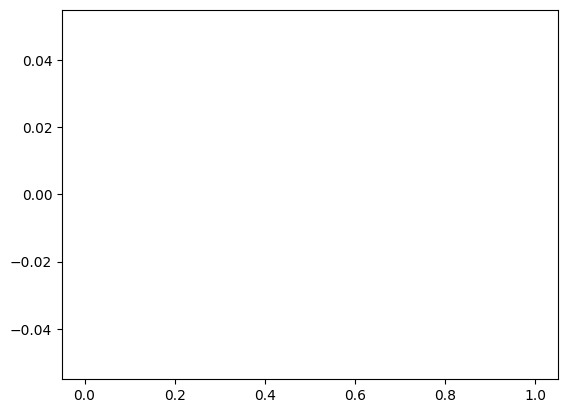

In [147]:
"115-S1"
"88-S1"
"52-S2"

count = 0

tripleEvents = []

for sample in muonHits["115-S1"]:
    for sample2 in muonHits["88-S1"]:
        if ((sample[2] == sample2[2]) and (sample[3] == sample2[3]) and (0 < sample[1]-sample2[1] < 4)):
            for sample3 in muonHits["52-S2"]:
                if ((sample3[2] == sample2[2]) and (sample3[3] == sample2[3]) and (0 < (sample3[1]-sample[1]) < 15)):
                    print(sample3[1]-sample[1])
                    print(sample[3])
                    print("Nhits: " + str(countNhits(sample3[2],sample3[3])))
                    plt.plot(time,sample[0], label="115-S1")
                    plt.plot(time,sample2[0], label="88-S1")
                    plt.plot(time,sample3[0], label="52-S2")
                    plt.xlim([0,100])
                    plt.legend()
                    plt.show()
                    tripleEvents.append(countNhits(sample3[2],sample3[3]))
            # plt.plot(time,sample[0], label="115-S1")
            # plt.plot(time,sample2[0], label="88-s1")
            # plt.xlim([0,100])
            # plt.legend()
            # plt.show()

plt.hist(tripleEvents)
plt.show()